In [40]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch
import copy
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.models.GSNN import GSNN

from sklearn.metrics import r2_score

from gsnn.optim.InputEdgeInferrer import InputEdgeInferrer

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimating input errors to infer novel input edges 

1. esimtate error using gradient descent on a trainable input edge parameter 
2. identify correlations between edge errors and input channels 

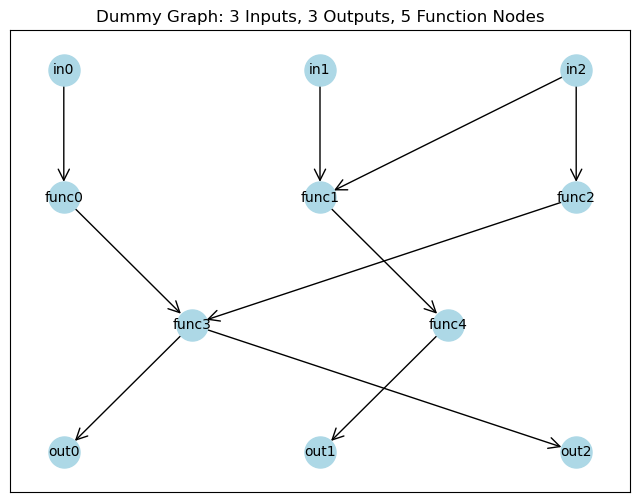

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2'), ('in2', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}

special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=25, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.15)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [4]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# simulate a missing edge (in2, func1)
edge_index_dict_TRUE = copy.deepcopy(data.edge_index_dict)

edge_index_dict = copy.deepcopy(data.edge_index_dict)

edge_index_dict['input', 'to', 'function'] = edge_index_dict['input', 'to', 'function'][:, :-1] # remove edge from in2 to func1 

data.edge_index_dict = edge_index_dict

In [5]:
model_kwargs = {'channels': 3, 
                'layers': 4, 
                'share_layers': False, 
                'bias': True, 
                'add_function_self_edges': True, 
                'norm': 'none', 
                'dropout': 0.0,
                'nonlin': torch.nn.LeakyReLU}


In [6]:
# train GSNN with a missing input edge  

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')


n params 381
test loss: 0.217 | test r2: 0.741


In [53]:
# freeze GSNN 
for p in model.parameters(): 
    p.requires_grad = False

# node channels 
nchannels = len(model.indices_params[4])

#node_errs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros((x_train.size(0), nchannels))) for _ in range(model.layers)])
node_errs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros((x_train.size(0), nchannels))) for _ in range(1)])

dropout = torch.nn.Dropout(0.)
optim = torch.optim.Adam(node_errs, lr=1e-4, weight_decay=1e-1)
crit = torch.nn.MSELoss()

for i in range(2000): 

    losses = [] 
    for idxs in torch.split(torch.randperm(x_train.size(0)), 100): 
        optim.zero_grad() 

        xx = x_train[idxs]
        yy = y_train[idxs]

        nerrs = [dropout(ne[idxs]) for ne in node_errs] + [None]*(model.layers - 1)

        yhat = model(xx, node_errs=nerrs)
        loss = crit(yy, yhat)
        loss.backward() 
        optim.step()

        losses.append(loss.item())

    print(f'iter: {i} | loss: {np.mean(losses):.3f}',end='\r')

In [54]:
res = {'channel_idx':[], 'function_group':[], 'x_idx':[], 'r':[], 'pval':[]}
for nc, func_idx in zip(range(node_errs[0].size(1)), model.indices_params[4]): 
    channel_err = node_errs[0][:, nc].detach().cpu().numpy()

    for x_idx in range(x_train.size(1)): 
        
        xx = x_train[:, x_idx].detach().cpu().numpy()

        cor = spearmanr(xx, channel_err)

        res['channel_idx'].append(nc)
        res['function_group'].append(func_idx)
        res['x_idx'].append(x_idx)
        res['r'].append(cor.statistic)
        res['pval'].append(cor.pvalue)

res = pd.DataFrame(res)

res = res.assign(func_name = [data.node_names_dict['function'][f] for f in res['function_group']])
res = res.assign(x_name = [data.node_names_dict['input'][f] for f in res['x_idx']])

res = res.assign(pval_adj = multipletests(res['pval'], method='fdr_bh')[1])
res.head()


,channel_idx,function_group,x_idx,r,pval,func_name,x_name,pval_adj
0,0,0,0,0.007692,0.970889,func0,in0,0.997088
1,0,0,1,0.030769,0.883918,func0,in1,0.997088
2,0,0,2,-0.014615,0.944720,func0,in2,0.997088
3,1,0,0,-0.017692,0.933105,func0,in0,0.997088
4,1,0,1,0.361538,0.075771,func0,in1,0.681937


In [55]:
res.sort_values('pval_adj')

,channel_idx,function_group,x_idx,r,pval,func_name,x_name,pval_adj
44,14,4,2,-0.877692,8.324712e-09,func4,in2,3.746120e-07
38,12,4,2,-0.799231,1.655163e-06,func4,in2,3.724117e-05
14,4,1,2,0.694615,1.168413e-04,func1,in2,1.752620e-03
11,3,1,2,-0.429231,3.226016e-02,func1,in2,3.629268e-01
4,1,0,1,0.361538,7.577073e-02,func0,in1,6.819365e-01
26,8,2,2,0.072308,7.312381e-01,func2,in2,9.970883e-01
27,9,3,0,0.050000,8.123860e-01,func3,in0,9.970883e-01
28,9,3,1,0.053077,8.010602e-01,func3,in1,9.970883e-01
29,9,3,2,0.050769,8.095510e-01,func3,in2,9.970883e-01
30,10,3,0,0.047692,8.209046e-01,func3,in0,9.970883e-01
